In [20]:
import fuzzylite as fl
import numpy as np
from matplotlib import pyplot as plt

age = fl.InputVariable(
    'age',
    enabled=True,
    minimum=0.0,
    maximum=1.0, 
    terms=[
            fl.Triangle("teenager", 0.25, 0.45, 0.65),
            fl.Triangle("adult", 0.45, 0.65, 0.85),
            fl.Trapezoid("infant", -1, 0, .25, 0.45),
            fl.Trapezoid("elderly", .65, .85, 1, 2),
        ],
)

In [21]:
age_vals = np.linspace(0, 1, 100)

In [22]:
def plot_variable(var, universe):
    plt.title(var.name)
    linguistic_terms_names = []
    vals = np.linspace(*universe, 100)
    
        
    for term in var.terms:
        membership_fn = [term.membership(e) for e in vals]
        plt.plot(vals, membership_fn)
        linguistic_terms_names.append(term.name)
    plt.legend(linguistic_terms_names)
    plt.xlabel(var.name)
    plt.ylabel('membership function')
    plt.show()

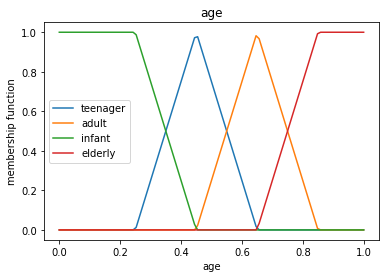

In [23]:
plot_variable(age, universe=(0, 1))

In [36]:
def generate_var_terms(universe: tuple[float], trapezoid_points: tuple[float], n_terms: int = 4) -> list[fl.Term]:
    """Generates terms given universe, trapezoid points and number of term

    Args:
        universe (tuple[float]): general universe of the variable
        trapezoid_points (tuple[float]): left/right 
        n_terms (int, optional): Number of terms. Defaults to 4.

    Returns:
        list[fl.Term]: list of terms
    """
    points = np.linspace(trapezoid_points[0], trapezoid_points[1], n_terms)
    terms = [fl.Trapezoid("first_bin", universe[0] - 1, universe[0], points[0], points[1]),
             fl.Trapezoid("last_bin", points[-2], points[-1], universe[1], universe[1] + 1),]
    
    if len(points) > 2: 
        for i in range(n_terms - 2):
            index = i + 2
            term = fl.Triangle(f'bin_{index}', points[i], points[i + 1], points[i + 2])
            terms.append(term)
    return terms


In [37]:
def check_bin_sizes_gendered(age_bins: int = 4, diversity_bins: int = 4):
    return age_bins ==  diversity_bins

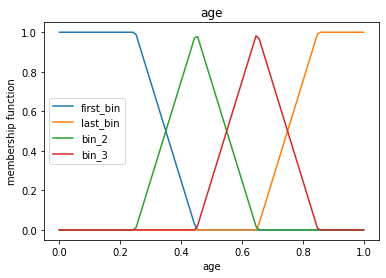

In [42]:
age_new = fl.InputVariable('age', enabled=True, minimum=0, maximum=1, 
                           terms=generate_var_terms(universe=(0, 1), trapezoid_points=(.25, .85), n_terms=4))

diversity_new =  fl.InputVariable('diversity', enabled=True, minimum=0, maximum=10, 
                           terms=generate_var_terms(universe=(0, 10), trapezoid_points=(2.5, 8.5), n_terms=4))
plot_variable(age_new, universe=(0, 1))

In [39]:
for i in age_new.terms:
    print(i.name)

first_bin
last_bin
bin_2
bin_3


In [17]:
def _generate_bin_name(index: int, n_bins: int) -> str:
    cat_name = None
    if index == 0:
        cat_name = 'first_bin'
    elif index < n_bins - 1:
        cat_name = f'bin_{index+1}'
    elif index == n_bins - 1:
        cat_name = f'last_bin'
    return cat_name

def _format_rule(cat1:str, cat2:str, cat3:str) -> str:
    return f'if age is {cat1} and diversity is {cat2} then partner_age is {cat3}'


def generate_gendered_rules(n_bins: int =  4) -> list[str]:
    """Generates rules for partner age given number of bins
    Args:
        n_bins (int, optional): _description_. Defaults to 4.

    Returns:
        list[str]: rules
    """
    rules = []
    for i in range(n_bins):
        age_cat_name: str = _generate_bin_name(i, n_bins)
        for j in range(n_bins):
            diversity_cat_name: str = _generate_bin_name(j, n_bins)

            if i != n_bins - 1:
                age_cat_partner_index = n_bins - j - 1

                if j != n_bins - 1:
                    partner_age_names = _generate_bin_name(age_cat_partner_index, n_bins), _generate_bin_name(age_cat_partner_index - 1, n_bins)
                    for p_age_name in partner_age_names:
                        rule = _format_rule(age_cat_name, diversity_cat_name, p_age_name)
                        rules.append(rule)
                else:
                    partner_age_names = _generate_bin_name(age_cat_partner_index, n_bins)
                    rule = _format_rule(age_cat_name, diversity_cat_name, partner_age_names)
                    rules.append(rule)
            else:

                if j < n_bins - 2:
                    age_cat_partner_index = n_bins - j - 2
                    partner_age_names = _generate_bin_name(age_cat_partner_index, n_bins), _generate_bin_name(age_cat_partner_index - 1, n_bins)
                    for p_age_name in partner_age_names:
                        rule = _format_rule(age_cat_name, diversity_cat_name, p_age_name)
                        rules.append(rule)
                else:
                    age_cat_partner_index = 0
                    partner_age_names = _generate_bin_name(age_cat_partner_index, n_bins)
                    rule = _format_rule(age_cat_name, diversity_cat_name, partner_age_names)
                    rules.append(rule)
    return rules


In [18]:
generate_gendered_rules(4)

['if age is first_bin and diversity is first_bin then partner_age is last_bin',
 'if age is first_bin and diversity is first_bin then partner_age is bin_3',
 'if age is first_bin and diversity is bin_2 then partner_age is bin_3',
 'if age is first_bin and diversity is bin_2 then partner_age is bin_2',
 'if age is first_bin and diversity is bin_3 then partner_age is bin_2',
 'if age is first_bin and diversity is bin_3 then partner_age is first_bin',
 'if age is first_bin and diversity is last_bin then partner_age is first_bin',
 'if age is bin_2 and diversity is first_bin then partner_age is last_bin',
 'if age is bin_2 and diversity is first_bin then partner_age is bin_3',
 'if age is bin_2 and diversity is bin_2 then partner_age is bin_3',
 'if age is bin_2 and diversity is bin_2 then partner_age is bin_2',
 'if age is bin_2 and diversity is bin_3 then partner_age is bin_2',
 'if age is bin_2 and diversity is bin_3 then partner_age is first_bin',
 'if age is bin_2 and diversity is las

In [44]:
partner_age_new = fl.OutputVariable(
    'partner_age',
    enabled=True,
    minimum=0.0,
    maximum=1.0, 
    terms=generate_var_terms(universe=(0, 1), trapezoid_points=(.25, .85), n_terms=4),
    defuzzifier=fl.Centroid(),
    aggregation=fl.Maximum(),
)

In [45]:
engine = fl.Engine(name="approximation", description="")
engine.input_variables = [age_new, diversity_new]
engine.output_variables = [partner_age_new]

In [48]:
engine.rule_blocks = [
            fl.RuleBlock(
        name="",
        description="",
        enabled=True,
        conjunction=fl.Minimum(),
        disjunction=fl.Maximum(),
        implication=fl.Minimum(),
        activation=fl.General(),
        rules= [fl.Rule.create(rule.strip(), engine) for rule in generate_gendered_rules(4)])]

In [49]:
age_new.value = .3
diversity_new.value = 3.8
engine.process()
partner_age_new.value

0.6130861244019137

In [50]:
from src.gendered_selection.faster_fuzzy_logic.infer_partner_age import Inferrer

In [51]:
inferr = Inferrer(rule_path='src/gendered_selection/conf/rules_ref.txt')
inferr.infer_partner_age(.3, 3.8)

In [59]:
class GeneralizedInferrer(object):
    def __init__(self, n_partitions: int) -> None:
        self.age = fl.InputVariable('age', enabled=True, minimum=0, maximum=1, 
                           terms=generate_var_terms(universe=(0, 1), trapezoid_points=(.25, .85), n_terms=n_partitions))
        
        self.diversity =  fl.InputVariable('diversity', enabled=True, minimum=0, maximum=10, 
                           terms=generate_var_terms(universe=(0, 10), trapezoid_points=(2.5, 8.5), n_terms=n_partitions))
        self.partner_age = fl.OutputVariable(
            'partner_age',
            enabled=True,
            minimum=0.0,
            maximum=1.0, 
            terms=generate_var_terms(universe=(0, 1), trapezoid_points=(.25, .85), n_terms=4),
            defuzzifier=fl.Centroid(),
            aggregation=fl.Maximum()
        )
        self.engine = fl.Engine(name="approximation", description="")
        self.engine.input_variables = [self.age, self.diversity]
        self.engine.output_variables = [self.partner_age]

        self.engine.rule_blocks = [
            fl.RuleBlock(
            name="",
            description="",
            enabled=True,
            conjunction=fl.Minimum(),
            disjunction=fl.Maximum(),
            implication=fl.Minimum(),
            activation=fl.General(),
            rules= [fl.Rule.create(rule.strip(), self.engine) for rule in generate_gendered_rules(n_bins=n_partitions)])]
    
    def infer_partner_age(self, age, diversity) -> float:
        self.age.value = age
        self.diversity.value = diversity

        self.engine.process()


        return self.partner_age.value

In [60]:
gpi = GeneralizedInferrer(n_partitions=4)
gpi.infer_partner_age(.3, 3.8)

0.6130861244019137